In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
! pip install chembl_webresource_client

In [3]:
import pandas as pd
from chembl_webresource_client.new_client import new_client
target = new_client.target
target_query = target.search("coronavirus")
targets = pd.DataFrame.from_dict(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Coronavirus,Coronavirus,17.0,False,CHEMBL613732,[],ORGANISM,11119
1,[],SARS coronavirus,SARS coronavirus,15.0,False,CHEMBL612575,[],ORGANISM,227859
2,[],Feline coronavirus,Feline coronavirus,15.0,False,CHEMBL612744,[],ORGANISM,12663
3,[],Human coronavirus 229E,Human coronavirus 229E,13.0,False,CHEMBL613837,[],ORGANISM,11137
4,"[{'xref_id': 'P0C6U8', 'xref_name': None, 'xre...",SARS coronavirus,SARS coronavirus 3C-like proteinase,10.0,False,CHEMBL3927,"[{'accession': 'P0C6U8', 'component_descriptio...",SINGLE PROTEIN,227859
5,[],Middle East respiratory syndrome-related coron...,Middle East respiratory syndrome-related coron...,9.0,False,CHEMBL4296578,[],ORGANISM,1335626
6,"[{'xref_id': 'P0C6X7', 'xref_name': None, 'xre...",SARS coronavirus,Replicase polyprotein 1ab,4.0,False,CHEMBL5118,"[{'accession': 'P0C6X7', 'component_descriptio...",SINGLE PROTEIN,227859
7,[],Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,4.0,False,CHEMBL4523582,"[{'accession': 'P0DTD1', 'component_descriptio...",SINGLE PROTEIN,2697049


In [4]:
selected_target = targets.target_chembl_id[4]
selected_target
activity = new_client.activity

res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")
df = pd.DataFrame.from_dict(res)

df.to_csv('coronavirus_bioactivity_data_raw.csv', index=False)

df2 = df[df.standard_value.notna()]
df2 = df2[df.canonical_smiles.notna()]
df2_nr = df2.drop_duplicates(['canonical_smiles'])

selection = ['molecule_chembl_id','canonical_smiles','standard_value']
df3 = df2[selection]

df3.to_csv('coronavirus_bioactivity_data_preprocessed.csv', index=False)

df4 = pd.read_csv('coronavirus_bioactivity_data_preprocessed.csv')

bioactivity_threshold = []
for i in df4.standard_value:
  if float(i) >= 10000:
    bioactivity_threshold.append("inactive")
  elif float(i) <= 1000:
    bioactivity_threshold.append("active")
  else:
    bioactivity_threshold.append("intermediate")
    
bioactivity_class = pd.Series(bioactivity_threshold, name='class')
df5 = pd.concat([df4, bioactivity_class], axis=1)
df5
df5.to_csv('coronavirus_bioactivity_data.csv', index=False)

from zipfile import ZipFile
zipcoronavirus = ZipFile('coronavirus_bioactivity_data.zip', 'w')
zipcoronavirus.write('coronavirus_bioactivity_data_preprocessed.csv')
zipcoronavirus.write('coronavirus_bioactivity_data.csv')
zipcoronavirus.write('coronavirus_bioactivity_data_raw.csv')
zipcoronavirus.close()
df5

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0,intermediate
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0,intermediate
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0,inactive
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.0,inactive
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.0,intermediate
...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,10600.0,inactive
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,10100.0,inactive
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,11500.0,inactive
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,10700.0,inactive


In [5]:
import numpy as np
import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors,Lipinski

In [6]:
df_no_smiles = df5.drop(columns='canonical_smiles')
smiles = []

for i in df5.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

df_clean_smiles = pd.concat([df_no_smiles,smiles], axis=1)

In [7]:
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

df_lipinski = lipinski(df_clean_smiles.canonical_smiles)
df_combined = pd.concat([df5,df_lipinski], axis=1)
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0,intermediate,281.271,1.89262,0.0,5.0
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0,intermediate,415.589,3.81320,0.0,2.0
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0,inactive,421.190,2.66050,0.0,4.0
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.0,inactive,293.347,3.63080,0.0,3.0
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.0,intermediate,338.344,3.53900,0.0,5.0
...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,10600.0,inactive,338.359,3.40102,0.0,5.0
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,10100.0,inactive,296.366,3.44330,0.0,3.0
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,11500.0,inactive,276.291,4.09564,0.0,3.0
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,10700.0,inactive,278.307,3.29102,0.0,3.0


In [8]:
def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
    
        
    return x

In [9]:
df_combined.standard_value.describe()
-np.log10( (10**-9)* 100000000 )
-np.log10( (10**-9)* 10000000000 )

-1.0

In [10]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x

In [11]:
df_norm = norm_value(df_combined)
df_norm

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,intermediate,281.271,1.89262,0.0,5.0,7200.0
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,intermediate,415.589,3.81320,0.0,2.0,9400.0
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0.0,4.0,13500.0
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0.0,3.0,13110.0
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],intermediate,338.344,3.53900,0.0,5.0,2000.0
...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,inactive,338.359,3.40102,0.0,5.0,10600.0
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,inactive,296.366,3.44330,0.0,3.0,10100.0
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,inactive,276.291,4.09564,0.0,3.0,11500.0
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,inactive,278.307,3.29102,0.0,3.0,10700.0


In [12]:
df_final = pIC50(df_norm)
df_final

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,intermediate,281.271,1.89262,0.0,5.0,5.142668
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,intermediate,415.589,3.81320,0.0,2.0,5.026872
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0.0,4.0,4.869666
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0.0,3.0,4.882397
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],intermediate,338.344,3.53900,0.0,5.0,5.698970
...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,inactive,338.359,3.40102,0.0,5.0,4.974694
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,inactive,296.366,3.44330,0.0,3.0,4.995679
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,inactive,276.291,4.09564,0.0,3.0,4.939302
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,inactive,278.307,3.29102,0.0,3.0,4.970616


In [13]:
df_final.to_csv('coronavirus_bioactivity_data_3class_pIC50.csv')

In [14]:
df_2class = df_final[df_final['class'] != 'intermediate']
df_2class

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0.0,4.0,4.869666
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0.0,3.0,4.882397
5,CHEMBL365134,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c(Br)cccc21,active,372.243,4.39330,0.0,3.0,6.008774
7,CHEMBL190743,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccc(I)cc21,active,419.243,4.23540,0.0,3.0,6.022276
8,CHEMBL365469,O=C1C(=O)N(Cc2cc3ccccc3s2)c2cccc(Cl)c21,inactive,327.792,4.28420,0.0,3.0,4.950782
...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,inactive,338.359,3.40102,0.0,5.0,4.974694
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,inactive,296.366,3.44330,0.0,3.0,4.995679
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,inactive,276.291,4.09564,0.0,3.0,4.939302
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,inactive,278.307,3.29102,0.0,3.0,4.970616


In [15]:
df_2class.to_csv('coronavirus_bioactivity_data_2class_pIC50.csv')

In [16]:
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh
! unzip padel.zip

--2021-09-27 09:27:16--  https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
Resolving github.com (github.com)... 15.164.81.167
Connecting to github.com (github.com)|15.164.81.167|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip [following]
--2021-09-27 09:27:16--  https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25768637 (25M) [application/zip]
Saving to: ‘padel.zip.15’

padel.zip.15        100%[===================>]  24.57M  1.20MB/s    in 24s     

2021-09-27 09:27:41 (1.01 MB/s) - ‘padel.zip.15’ saved [25768637/25768637]

--2021-09-27 09:27:41--  https

In [17]:
import pandas as pd

In [18]:
selection = ['canonical_smiles','molecule_chembl_id']
df_2class_selection = df_2class[selection]
df_2class_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [19]:
! cat molecule.smi | head -5
! cat molecule.smi | wc -l
! cat padel.sh
! bash padel.sh
! ls -l

O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21	CHEMBL185698
O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21	CHEMBL426082
O=C1C(=O)N(Cc2cc3ccccc3s2)c2c(Br)cccc21	CHEMBL365134
O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccc(I)cc21	CHEMBL190743
O=C1C(=O)N(Cc2cc3ccccc3s2)c2cccc(Cl)c21	CHEMBL365469
119
java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml -dir ./ -file descriptors_output.csv
Processing CHEMBL426082 in molecule.smi (2/119). 
Processing CHEMBL185698 in molecule.smi (1/119). 
Processing CHEMBL190743 in molecule.smi (4/119). 
Processing CHEMBL365134 in molecule.smi (3/119). 
Processing CHEMBL365469 in molecule.smi (5/119). Average speed: 1.83 s/mol.
Processing CHEMBL188983 in molecule.smi (6/119). Average speed: 1.03 s/mol.
Processing CHEMBL191575 in molecule.smi (7/119). Average speed: 0.69 s/mol.
Processing CHEMBL370923 in molecule.smi (8/119). Average speed: 0.70 s/mol.
P

Processing CHEMBL363535 in molecule.smi (103/119). Average speed: 0.08 s/mol.
Processing CHEMBL227075 in molecule.smi (104/119). Average speed: 0.08 s/mol.
Processing CHEMBL215254 in molecule.smi (106/119). Average speed: 0.08 s/mol.
Processing CHEMBL45830 in molecule.smi (105/119). Average speed: 0.08 s/mol.
Processing CHEMBL187460 in molecule.smi (107/119). Average speed: 0.08 s/mol.
Processing CHEMBL45830 in molecule.smi (108/119). Average speed: 0.08 s/mol.
Processing CHEMBL215254 in molecule.smi (109/119). Average speed: 0.08 s/mol.
Processing CHEMBL363535 in molecule.smi (111/119). Average speed: 0.08 s/mol.
Processing CHEMBL187460 in molecule.smi (110/119). Average speed: 0.08 s/mol.
Processing CHEMBL45830 in molecule.smi (112/119). Average speed: 0.08 s/mol.
Processing CHEMBL187266 in molecule.smi (113/119). Average speed: 0.08 s/mol.
Processing CHEMBL215254 in molecule.smi (114/119). Average speed: 0.08 s/mol.
Processing CHEMBL2146517 in molecule.smi (115/119). Average speed: 

In [20]:
! ls -l

total 3287316
-rw-rw-r-- 1 hschoung0124 hschoung0124     27479  9월 18 00:24  4990f84321d00f66799c63220ff4948d.jpg
-rw-rw-r-- 1 hschoung0124 hschoung0124     49254  9월 18 00:25  85821c3d3ec5225013d67a292f2c3fd2.jpg
-rw-rw-r-- 1 hschoung0124 hschoung0124    385924  9월 24 00:22  acetylcholinesterase_03_bioactivity_data_curated.csv
-rw-rw-r-- 1 hschoung0124 hschoung0124  37419422  9월 17 09:36  Anaconda3-2018.12-Linux-x86_64.sh
-rw-rw-r-- 1 hschoung0124 hschoung0124 570853747  9월 14 09:30 'Anaconda3-2021.05-Linux-x86_64(1).sh'
-rw-rw-r-- 1 hschoung0124 hschoung0124 570853747  9월 10 16:02  Anaconda3-2021.05-Linux-x86_64.sh
-rw-rw-r-- 1 hschoung0124 hschoung0124     45013  9월 24 00:23  CDD_ML_Part_2_Acetylcholinesterase_Exploratory_Data_Analysis.ipynb
-rw-rw-r-- 1 hschoung0124 hschoung0124  75908016  9월 10 11:15  code_1.60.0-1630494279_amd64.deb
-rw-rw-r-- 1 hschoung0124 hschoung0124     15384  9월 27 09:27  coronavirus_bioactivity_data_2class_pIC50.csv
-rw-rw-r-- 1 hschoung0124 hschoung0124  

In [21]:
X = pd.read_csv('descriptors_output.csv')

In [22]:
X

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL426082,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL190743,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL365134,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL185698,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL365469,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,CHEMBL187460,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
115,CHEMBL227075,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
116,CHEMBL363535,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
117,CHEMBL2146517,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
Y = df_2class['pIC50']
Y

2      4.869666
3      4.882397
5      6.008774
7      6.022276
8      4.950782
         ...   
128    4.974694
129    4.995679
130    4.939302
131    4.970616
132    4.102923
Name: pIC50, Length: 119, dtype: float64

In [24]:
dataset3 = pd.concat([X,Y], axis=1)
dataset3

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,CHEMBL426082,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,CHEMBL190743,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,CHEMBL365134,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.869666
3,CHEMBL185698,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.882397
4,CHEMBL365469,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.974694
129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.995679
130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.939302
131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.970616


In [25]:
dataset3.to_csv('coronavirus_bioactivity_data_3class_pIC50_pubchem_fp.csv', index=False)

In [26]:
import pandas as pd
! pip install seaborn
import seaborn as sns
! pip install sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [27]:
X.shape

(119, 882)

In [28]:
Y.shape

(119,)

In [29]:
X = X.drop(columns=['Name'])
X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
115,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
116,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
117,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [30]:
from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X = selection.fit_transform(X)

In [31]:
X.shape

(119, 197)

In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [33]:
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, Y_train)
r2 = model.score(X_test, Y_test)
r2

0.2361681220630878

In [34]:
Y_pred = model.predict(X_test)

<function matplotlib.pyplot.show(close=None, block=None)>

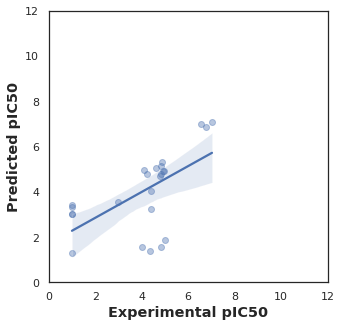

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(Y_test, Y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show